# Classification - analyse de sentiments

- Import du jeu de données et statistiques
- Nettoyage de données et modélisation
- Enrichir le modèle (POS, lemmatisation, ponctuation, dictionnaire de sentiments) </br> 

*NB : Le notebook repose sur le jeu de données IMDB_dataset.csv <br>
Ce jeu de données est très connu en analyse du langage dans la communauté de recherche. Il est composé de revues de film avec le sentiment associé à cette dernière. L'objectif est de prédire ce sentiment connaissant le commentaire de l'utilisateur.*

In [1]:
#Libraries python par défaut
import pandas as pd
pd.options.mode.chained_assignment = None  
import numpy as np
from collections import defaultdict
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Import de nltk - nous en aurons besoin pour certains outils spécifiques associés à l'analyse de Sentiment (Sentiwordnet)
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk import sent_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords

import spacy
nlp = spacy.load("en_core_web_sm")

#Cette fonction sert à diviser les données pour créer des jeux d'entrainement, de validation, et de test
from sklearn.model_selection import train_test_split

#Pour la modélisation par Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

#Cette fonction va nous servir à concaténer notre matrice de Bag of Words avec les variables supplémentaires que nous allons créer
from scipy.sparse import hstack

#Le modèle de prédiction et les métriques de test
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

## Analyse préliminaire des données

Ici nous allons voir comment encoder notre variable cible, vérifier le balancement du jeu de données, et voir l'état des textes que nous avons à analyser.

In [2]:
df = pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
#Encoding de notre variable cible en variable binaire exploitable pour un modèle prédictif
#Ici on applique un filtre de telle sorte que les sentiments positifs aient la valeur de 1 et les négatifs 0.
df['label'] = np.where(df['sentiment']!= 'positive', 0, 1)
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


1    25000
0    25000
Name: label, dtype: int64


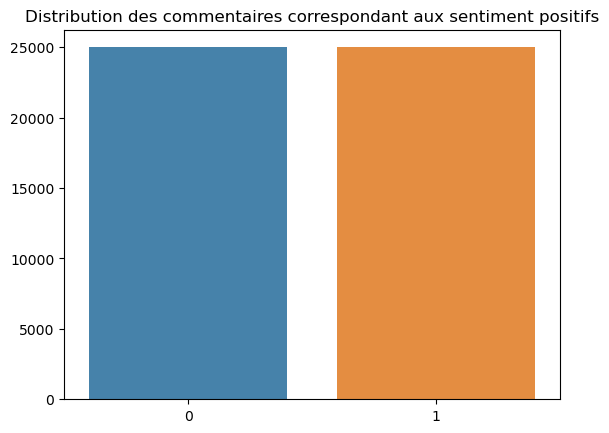

In [4]:
#On commence par explorer la répartition de nos classes. 
Y_distr = df['label'].value_counts()
print(df['label'].value_counts())
sns.barplot(x=Y_distr.index, y=Y_distr.values, alpha=0.9)
plt.title("Distribution des commentaires correspondant aux sentiment positifs")
plt.show()

In [5]:
#On crée notre liste de document et nos Y associés pour pouvoir les analyser plus en profondeur
X = list(df['review'])
Y = np.array(list(df['label']))

In [6]:
#Fonction de tokenisation simple pour obtenir des premières informations sur le texte afin de savoir quelles étapes faire par la suite
def tokenize(text):
    return [tok.text for tok in nlp.tokenizer(str(text))]

In [7]:
#Examiner les 3 premières revues de notre jeu de données
print(X[0:3])

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [8]:
#On va aussi regarder quels sont les tokens les plus occurrents pour obtenir une idée des variables à nettoyer
count_dict = collections.defaultdict(int)
for text in X:
    list_token = tokenize(text)
    for token in list_token:
        count_dict[token] += 1

#Ordonnancement du dictionnaire par valeur décroissante
sorted_count = sorted(count_dict.items(), key=lambda kv: kv[1], reverse=True)
sorted_count_dict = dict(collections.OrderedDict(sorted_count))

In [9]:
#Affichage de la liste des 100 premiers mots et de leur fréquence
print({k: sorted_count_dict[k] for k in list(sorted_count_dict)[:100]})

{'the': 574323, ',': 542893, '.': 468185, 'a': 309328, 'and': 309223, 'of': 285791, 'to': 264478, 'is': 214630, 'in': 174194, 'I': 155276, 'it': 151759, 'that': 138182, '"': 126795, "'s": 121638, 'this': 120301, '-': 104879, '/><br': 100974, 'was': 99119, 'as': 85000, 'movie': 84730, 'with': 84728, 'for': 82893, 'film': 77026, 'The': 75059, 'but': 68834, 'on': 65453, "n't": 65193, '(': 65043, ')': 64183, 'you': 61696, 'are': 59370, 'not': 57225, 'have': 56222, 'his': 54680, 'be': 52738, 'one': 48253, 'he': 48106, '!': 43915, 'at': 43407, 'by': 43040, 'all': 41970, 'an': 41399, 'who': 40519, 'from': 38656, 'they': 38652, 'like': 38498, 'so': 35119, 'or': 33977, 'about': 33524, 'has': 33435, 'out': 33345, "'": 33183, 'her': 33116, 'just': 32847, 'It': 32775, 'do': 31242, '?': 29841, 'some': 28500, 'good': 28173, 'more': 27218, 'very': 26394, 'would': 26305, 'up': 25768, 'what': 25575, 'This': 25059, 'there': 24918, 'time': 23802, 'can': 23429, 'when': 23148, 'if': 22865, 'which': 22688, 

## Nettoyage des données et modélisation

Nous allons éliminer les balises < /br > dans le texte qui sont des erreurs d'encoding quand on charge le fichier. Nous allons aussi créer quelques stopwords pour éliminer des mots grammaticaux. <br>
Finalement nous allons simplement faire une première modélisation du texte, sans faire aucun autre traitement afin d'obtenir une bonne première base pour prédire le sentiment. Cela nous sera très utile pour comprendre l'impact de nos ajouts par la suite.

*N.B : On ne veut pas forcément supprimer des variables comme les guillemets, les parenthèses, ou autre car en analyse de sentiment ça peut être un signal intéressant.*

In [10]:
#Première étape, on supprime les différents marqueurs de texte indésirables
def clean(text):
    text = re.sub("<br />", " ", text)
    return text

#On applique directement la fonction sur le dataframe de pandas
df['review'] = df['review'].apply(clean)

In [11]:
#On crée une liste de stopwords adaptée à notre contexte
nltk_stopEN = stopwords.words('english')
stopwords_perso = ['about', 'where', 'with', 'about', 'your', 'been', 'into', 'itself',  'them', 'their', 'theirs', 'themselves', 'what', 'there', 
                   'does', 'that', 'which', 'while', 'them', 'those', 'other', 'though', 'also', 'here','gestalt', 'they', ]
stopwords = nltk_stopEN + stopwords_perso

In [12]:
#Création de nos jeux de données train et test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 54321)

In [13]:
#Modélisation du texte en matrice de Bag Of Words
Count_vec = CountVectorizer(tokenizer=tokenize, min_df=2, stop_words=stopwords)
BoW_matrix_train = Count_vec.fit_transform(X_train)
BoW_matrix_test =  Count_vec.transform(X_test)

C:\Users\a\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\a\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [14]:
#On entraine le modèle de prédiction - régression logistique.
clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =1000)
clf_log.fit(BoW_matrix_train, Y_train)
y_pred_log = clf_log.predict(BoW_matrix_test)

In [15]:
#On mesure la qualité des prédictions de notre modèle avec les vraies données de notre jeu de test
print('Model Precision: ', precision_score(Y_test, y_pred_log))
print('Model Recall: ', recall_score(Y_test, y_pred_log))
print('Model F1_score: ', f1_score(Y_test, y_pred_log))


Model Precision:  0.8813758828145436
Model Recall:  0.8944783647464826
Model F1_score:  0.8878787878787879


## Enrichir la  représentation

88.8% de f1 score est déjà un très bon résultat pour une première phase.
Nous allons voir si nous pouvons améliorer les résultats de notre modèle de régression logistique en ajoutant des variables supplémentaires qui peuvent être intéressantes à considérer pour de l'analyse de sentiment.
On a créé différentes fonctions pour : 
- Lemmatiser le texte
- Utiliser les POS tagging pour compter le nombre d'adjectifs et d'adverbes dans chaque revue
- Compter la taille (le nombre de mots utilisés) de la revue
- Compter le nombre de mots en majuscule utilisés
- Compter le nombre de guillemets et de parenthèse utilisées
- Utiliser un dictionnaire de sentiment externe comme "SentiWordNet"

Nous allons ajouter ces variables à notre matrice de Bag of Words afin de créer un nouveau modèle les prenant en compte.

In [16]:
#Fonction de lemmatisation avec Spacy
def lemmatize(text):
    temp = []
    doc = nlp(text)
    for token in doc:
        temp.append(token.lemma_)
    return " ".join(temp)

In [17]:
#Fonction permettant d'obtenir le nombre d'adjectifs et d'adverbes dans les phrases
def count_adj(text):
    nb_adj = 0
    doc = nlp(text)
    for token in doc:
        if token.pos_ == 'ADJ':
            nb_adj += 1
    return nb_adj

def count_adv(text):
    nb_adv = 0
    doc = nlp(text)
    for token in doc:
        if token.pos_ == 'ADV':
            nb_adv += 1
    return nb_adv

In [18]:
#Fonction permettant d'obtenir la taille des phrases
def len_sent(text):
    sent_tok = tokenize(text)
    return len(sent_tok)

In [19]:
#Fonction pour obtenir le nombre de mots commençant par uns majuscule ou étant tout en majuscule
def nb_upper(text):
    
    sent_tok_upper = [w.text for w in nlp(text) if str(w).isupper() or str(w).istitle()]
    return len(sent_tok_upper)

In [20]:
#Fonctions comptant le nombre de guillemets et de parenthèses
def nb_guill(text):
    return len(re.findall(r'"',text))
    
def nb_parentheses(text):
    return len(re.findall(r"\(",text))

In [21]:
#Fonction utilisant un dictionnaire externe de données - ici SentiWordNet présent avec nltk
def penn_to_wn(tag):

    #On crée cette fonction préliminaire pour faire de l'unformisation des types de mots entre le lematiser et le pos tagger de nltk 
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def swn_polarity(text, ponderate = False):

    sentiment = np.zeros(2)
    pos_sentiment = 0
    neg_sentiment = 0
    norm = 0
    raw_sentences = sent_tokenize(text)
    #Pour chaque phrase de notre jeu de données
    for i, raw_sentence in enumerate(raw_sentences):
        #On utilise le pos tagger de nltk cette fois
        tagged_sentence = pos_tag([word for word in tokenize(raw_sentence) if word not in stopwords])
        
        #On initie notre score de sentiment
        pos_sentence_sentiment = 0
        neg_sentence_sentiment = 0
        
        #Pour chaque mot
        for word, tag in tagged_sentence:
            #On récupère l'équivalent de POS nécessaire pour le lemmatiser
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
                continue
             #On récupère le lemme du mot
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
             #On récupère le sentiment associé au lemme dans SentiWordNet
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            
            norm += 1
            
            #On prend le premier sens du mot en compte, c'est celui qui est le plus communément employé
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            pos_sentence_sentiment += swn_synset.pos_score()
            neg_sentence_sentiment += swn_synset.neg_score()
        
        #Si on veut prendre en compte la position des phrases dans le calcul des sentiments
        if ponderate:
            ponderation = abs(i-(len(raw_sentences)-1)/2)/((len(raw_sentences))/2)
            pos_sentiment += ponderation * pos_sentence_sentiment
            neg_sentiment += ponderation * neg_sentence_sentiment
        else:
            pos_sentiment += pos_sentence_sentiment
            neg_sentiment += neg_sentence_sentiment
    
    #on oublie pas de normaliser par la taille du texte (ici on préfère normaliser par le nombre de mots pris en compte)
    sentiment[0] = pos_sentiment / norm
    sentiment[1] = neg_sentiment / norm
    
    return sentiment

In [22]:
#On applique les différentes fonctions sur le texte du dataframe pour obtenir des colonnes contenant nos résultats
#ATTENTION : Ici comme on a beaucoup de données, certaines opérations peuvent être très longues.


df['taille_phrase'] = df['review'].apply(len_sent)
df['nb_adverbs'] = df['review'].apply(count_adv)

#df['polarity_absolute'] = df['review'].apply(swn_polarity)
df['review_lemm'] = df['review'].apply(lemmatize)
df['nb_adjectives'] = df['review'].apply(count_adj)
df['nb_uppercase'] = df['review'].apply(nb_upper)
df['nb_guillemets'] = df['review'].apply(nb_guill)
df['nb_parentheses'] = df['review'].apply(nb_parentheses)
#df['polarity_ponder'] = df['review'].apply(swn_polarity, args=(True,))

In [23]:
#Aperçu du nouveau dataframe avec les variables nouvellement créées
df.head()

,review,sentiment,label,taille_phrase,nb_adverbs,review_lemm,nb_adjectives,nb_uppercase,nb_guillemets,nb_parentheses
0,One of the other reviewers has mentioned that ...,positive,1,362,13,one of the other reviewer have mention that af...,32,40,0,1
1,A wonderful little production. The filming t...,positive,1,185,19,a wonderful little production . the film te...,14,14,2,1
2,I thought this was a wonderful way to spend ti...,positive,1,195,7,I think this be a wonderful way to spend time ...,18,23,6,2
3,Basically there's a family where a little boy ...,negative,0,157,9,basically there be a family where a little boy...,6,15,0,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,258,4,"Petter Mattei 's "" love in the Time of money ""...",25,34,2,0


In [24]:
#On applique notre fonction pour séparer nos données en jeu d'entrainement et de test/validation
df_train, df_test, = train_test_split(df, test_size=0.3, random_state = 54321)

In [25]:
#On crée nos listes de textes et de labels
X_train = list(df_train['review'])
Y_train = list(df_train['label'])
X_test = list(df_test['review'])
Y_test = list(df_test['label'])

#On crée aussi nos listes de variables supplémentaires
adv_train = np.array(df_train['nb_adverbs'].values)
adv_test = np.array(df_test['nb_adverbs'].values)
taille_phrase_train = np.array(df_train['taille_phrase'].values)
taille_phrase_test = np.array(df_test['taille_phrase'].values)

#Si on veut le faire avec l'analyse via SentiWordNet créée précédemment, on doit  changer la fonction pour np.stack car la variable de sentiment est déjà représentée sous forme de vecteur
#sentinet_train = np.stack(df_train['polarity_absolute'].values, axis=0)
#sentinet_test = np.stack(df_test['polarity_absolute'].values, axis=0)

In [26]:
adv_train

array([25, 11, 18, ..., 13, 16,  2], dtype=int64)

In [27]:
#On crée à nouveau notre modélisation par Bag of Words
Count_vec = CountVectorizer(tokenizer=tokenize, min_df=2, stop_words=stopwords)
BoW_matrix_train = Count_vec.fit_transform(X_train)
BoW_matrix_test =  Count_vec.transform(X_test)

#On concatène les informations provenant des variables grammaticales et de taille de la phrase
add_ons_train = np.c_[adv_train, taille_phrase_train]
add_ons_test = np.c_[adv_test, taille_phrase_test]
train_matrix_full = hstack((BoW_matrix_train, add_ons_train))
test_matrix_full = hstack((BoW_matrix_test, add_ons_test))

C:\Users\a\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\a\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [28]:
print('Taille originale de la matrice de Bag of Words : ', BoW_matrix_train.shape)
print("Taille originale de la matrice de Bag of Words AVEC l'ajout des variables : ", train_matrix_full.shape)

Taille originale de la matrice de Bag of Words :  (35000, 53393)
Taille originale de la matrice de Bag of Words AVEC l'ajout des variables :  (35000, 53395)


In [29]:
#On applique notre modèle de régression logistique sur notre nouvelle matrice
clf_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter =5000)
clf_log.fit(train_matrix_full, Y_train)
y_pred_log = clf_log.predict(test_matrix_full)

In [30]:
#On affiche les nouvelles performances de notre modèle enrichit
print('Model Precision: ', precision_score(Y_test, y_pred_log))
print('Model Recall: ', recall_score(Y_test, y_pred_log))
print('Model F1_score: ', f1_score(Y_test, y_pred_log))

Model Precision:  0.8827370070514494
Model Recall:  0.8972657286965755
Model F1_score:  0.889942074776198


Ici on voit que nos ajouts ont légèrement amélioré les performances de notre modèle. <br>
Cependant peut être que d'autres combinaisons seront plus ou moins utiles. Il faudrait alors tester l'ensemble des variables de manière itérative afin d'identifier la meilleure combinaison possible. <br>
